# Machine Learning Model Implementations
This file includes machine learning model implementations and optimization steps.
The models used in order is as follows:
1. KNN classifier
2. ...


### Import Packages and Load Dataset

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM   = SLEEP-REM \
2 = Light = SLEEP-S1 and  SLEEP-S2 \
3 = Deep  = SLEEP-S3 

EMFIT is the piezoelectric mat and Somnofy is the radar.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

import numpy as np
from helpers import *
from plot import *

In [2]:
subjectID = PARTICIPANT_IDS[3]
sleep_stages, nan_counts = impute_data(subjectID)
print(nan_counts)

(0, 0, 0)


In [3]:
labels = sleep_stages["sleep_stage_num_psg"]
features = sleep_stages.drop(columns="sleep_stage_num_psg")
size = sleep_stages.shape[0]
divide_ind = int(size*.7)

In [4]:
print("Radar: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_somnofy"][:divide_ind]))
print("Mat: ", balanced_accuracy_score( labels[:divide_ind], sleep_stages["sleep_stage_num_emfit"][:divide_ind]))

Radar:  0.3952575396197906
Mat:  0.32039831725701035


<AxesSubplot:xlabel='timestamp_local'>

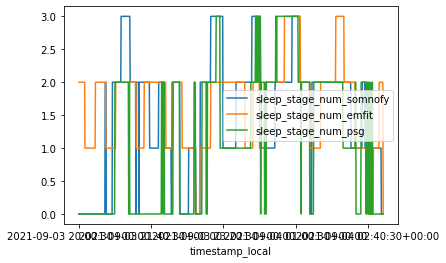

In [5]:
sleep_stages.plot()

### KNN Classifier

In [6]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(features[:divide_ind], labels[:divide_ind])

KNeighborsClassifier(n_neighbors=7)

In [7]:
preds = knn_classifier.predict(features[divide_ind:])

0.6155860071301248
[[64 12 43  0]
 [ 0  0  0  0]
 [ 2 19 67  0]
 [ 0  3 26 17]]


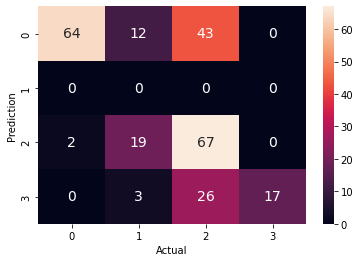

              precision    recall  f1-score   support

         0.0       0.97      0.54      0.69       119
         1.0       0.00      0.00      0.00         0
         2.0       0.49      0.76      0.60        88
         3.0       1.00      0.37      0.54        46

    accuracy                           0.58       253
   macro avg       0.62      0.42      0.46       253
weighted avg       0.81      0.58      0.63       253



/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Accuracy score 
print(balanced_accuracy_score( labels[divide_ind:], preds))

# Confusion Matrix and Classification Report 
plot_conf_matrix(preds, labels[divide_ind:])
print(classification_report(preds, labels[divide_ind:]))